________________
# Jack's Money Went Here 

Where is twitter likely to lean more and less now that he's leaving? Where will there be matching donations?

Jack Dorsey is pledging over 466 million dollars and wants matching donations. His rational is simple -- billionaires can spare a tithe to help communities and people, and compounded over a few hundred of his closest friends, have a tremendous impact. What edifice could be built with donations to these entities? What do their service offerings look like when seen as a whole? What are their moving parts?

This dataset is based off of the tweet https://twitter.com/jack/status/1247616214769086465 which lists pledged organizations and their donation. 
__________________________________________________________________

We will learn how to quickly data science this dataset. We will select feature representations and visualize the resulting graph using UMAP.

Featurization is the foundation of datascience. Likewise, Graph Thinking requires edges between nodes. Many times the data we have from databases/dataframes is tabular and row like -- with no incling of an edge table. This does *not* have to be an impediment for *Graph Thinking and materialization of datascience workflows*. 

UMAP is a powerful tool that projects complex, heterogeneous data coming from potentially many different distributions, down to lower dimensional embeddings and projections. The embedding estimates similarity between the rows, or nodes of the data, and thus forms a graph. 

Standardizing a feature set across the databases used in every modern company and then sending it to UMAP serves as a powerful graph generation tool.  
__________________________________________________________________

Here we demonstrate how to Featurize and use UMAP to generate implicit graphs. The features may then be used in subsequent modeling using your favorite libraries -- sklearn, tensorflow, pytorch[, geometric, lightening, ...], cuGraph, DGL, etc. We demonstrate 4 featurization methods -- 

* latent embeddings, 
* transformer embeddings, 
* ngrams embeddings, 
* one-hot encodings

that may be mixed and used to make different features for different columns, automatically. 

Furthermore, when we `g.plot()` the results, it is layed out according to the 2-dimensional UMAP projection of the data -- nearness in that projection represents nearness in the resulting features. We will test this empirically using the different featurization methods for textual, numeric and categorical data. 

In [1]:
#!pip install graphistry[ai]  # install the AI dependencies of Graphistry

In [1]:
import os

import pandas as pd
import graphistry
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
np.random.seed(137)

In [3]:
RENDER=False  # set to True for inline Graphistry Plots

In [5]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username=os.environ['USERNAME'], password=os.environ['GRAPHISTRY_PASSWORD'])

## Data loading & cleaning
We already added the dataset from the twitter link, downloading a copy (as of May 2022) from the google drive. We need to remove the first few rows to make a valid dataframe. 

In [4]:
df = pd.read_csv('https://gist.githubusercontent.com/silkspace/f8d7b8f279a5ffbd710c301fc402ec43/raw/95a722f5c65812322eaf085c1123b58d3ec3da3a/jack_donations.csv')
df = df.fillna('')
columns = df.iloc[3].values  
ndf = pd.DataFrame(df[4:].values, columns=columns)
ndf.head()

,Date,Amount,Category,Grantee,Twitter,Link,Why?
0,3/21/2022,"$2,000,000",Social Justice,REFORM Alliance,@REFORM,https://reformalliance.com,REFORM Alliance is committed to transforming t...
1,3/10/2022,"$1,000,000",Crisis Relief,World Central Kitchen,@WCKitchen,https://wck.org/,World Central Kitchen is serving thousands of ...
2,3/10/2022,"$1,000,000",Crisis Relief,Sunflower of Peace,@SunflowerFund,https://www.sunflowerofpeace.com,Sunflower of Peace is providing medical and hu...
3,3/10/2022,"$1,000,000",Crisis Relief,"Razom, Inc.",@razomforukraine,https://razomforukraine.org,Razom is supporting Ukrainian people in their ...
4,3/10/2022,"$1,000,000",Crisis Relief,Nova Ukraine,@novaukraine,https://novaukraine.org,"Nova Ukraine, a Bay Area-based humanitarian no..."


Notice that the Category labels are mixed and interwoven. 
We will show how to standardize it without having to do data cleaning or mapping

In [5]:
ndf.Category.unique()  # seems like there are 4-6 topics here

array(['Social Justice', 'Crisis Relief',
       'COVID-19, Girls Health & Education',
       'Social Justice, Girls Health & Education', 'COVID-19',
       'Social Justice, COVID-19', 'Girls Health & Education',
       'UBI, Social Justice', 'Girls Health & Education, COVID-19',
       'COVID-19, Social Justice', 'UBI',
       'COVID-19, Social Justice, Girls Health & Education',
       'Girls Health & Education; COVID-19', 'COVID-19; Social Justice',
       'Girls Health & Education; Social Justice',
       'COVID-19; Girls Health & Education', 'UBI; COVID-19',
       'COVID-19 & Social Justice',
       'Social Justice, UBI, Girls Health & Education', 'COVID-19, UBI',
       "Where it's needed most", 'COVID-19 '], dtype=object)

# Featurize

We will use `g.umap` to featurize and create edges. The details of how UMAP is able to create edges between rows in the data is beyond the scope of this tutorial, however, suffic it to say, it is automatically inferring a network of related entities based off their column features. 

Here is the dataset as graph, 


In [8]:
g = graphistry.nodes(ndf).umap()
g.bind(point_title='Grantee').plot(render=RENDER)  # fly around the clusters and click on nodes and edges. 

* Ignoring target column of shape (285, 0) in UMAP fit, as it is not one dimensionalOMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'https://hub.graphistry.com/graph/graph.html?dataset=ae47f85d8eaa4edfa6a3bc0c1124e313&type=arrow&viztoken=41ef5acc-41e3-49e9-99ac-2a57158b31c8&usertag=f680a57a-pygraphistry-0.28.7&splashAfter=1672009074&info=true&play=0'

The above featurized every column over the entire datase. Exploring the nodes and their nearest neighbors indeed clusters similar rows -- all in two lines of code!

## Light analysis and enrichment 

Lets convert Amount column into numeric, and then see who is getting what by category and grantee.

In [7]:
#ndf.columns
ndf[' Amount ']

0      $2,000,000
1      $1,000,000
2      $1,000,000
3      $1,000,000
4      $1,000,000
          ...    
280       $13,333
281    $2,000,000
282    $1,000,000
283    $2,100,000
284      $100,000
Name:  Amount , Length: 285, dtype: object

In [8]:
# let's convert money into float money (get it?)
from re import sub
from decimal import Decimal

def convert_money_string_to_float(money: str, return_float: bool = True):
    value = Decimal(sub(r"[^\d\-.]", "", money))  # preserves minus signs
    if return_float:
        return float(value)
    return value

ndf['$ amount'] = ndf[' Amount '].apply(lambda x: convert_money_string_to_float(x))

In [9]:
ndf['$ amount']

0      2000000.0
1      1000000.0
2      1000000.0
3      1000000.0
4      1000000.0
         ...    
280      13333.0
281    2000000.0
282    1000000.0
283    2100000.0
284     100000.0
Name: $ amount, Length: 285, dtype: float64

Many of these categories are not distinct. But due to data coming in with different notation, it seems distinct. 

We will show in the next section how to deal with this by using the graphistry pipeline to convert the `Category` into a latent target that organizes the labels.


In [10]:
current_funding_by_category = ndf.groupby('Category')['$ amount'].sum()
current_funding_by_category.map(lambda x: '${:3,}'.format(x))

Category
COVID-19                                              $153,882,590.0
COVID-19                                               $85,019,328.0
COVID-19 & Social Justice                                 $505,468.0
COVID-19, Girls Health & Education                      $4,265,000.0
COVID-19, Social Justice                                $1,800,000.0
COVID-19, Social Justice, Girls Health & Education        $250,000.0
COVID-19, UBI                                           $8,000,000.0
COVID-19; Girls Health & Education                      $9,920,000.0
COVID-19; Social Justice                                $5,090,080.0
Crisis Relief                                           $7,500,000.0
Girls Health & Education                               $30,300,000.0
Girls Health & Education, COVID-19                      $1,250,000.0
Girls Health & Education; COVID-19                     $12,000,000.0
Girls Health & Education; Social Justice                $2,500,000.0
Social Justice           

<Axes: xlabel='Category'>

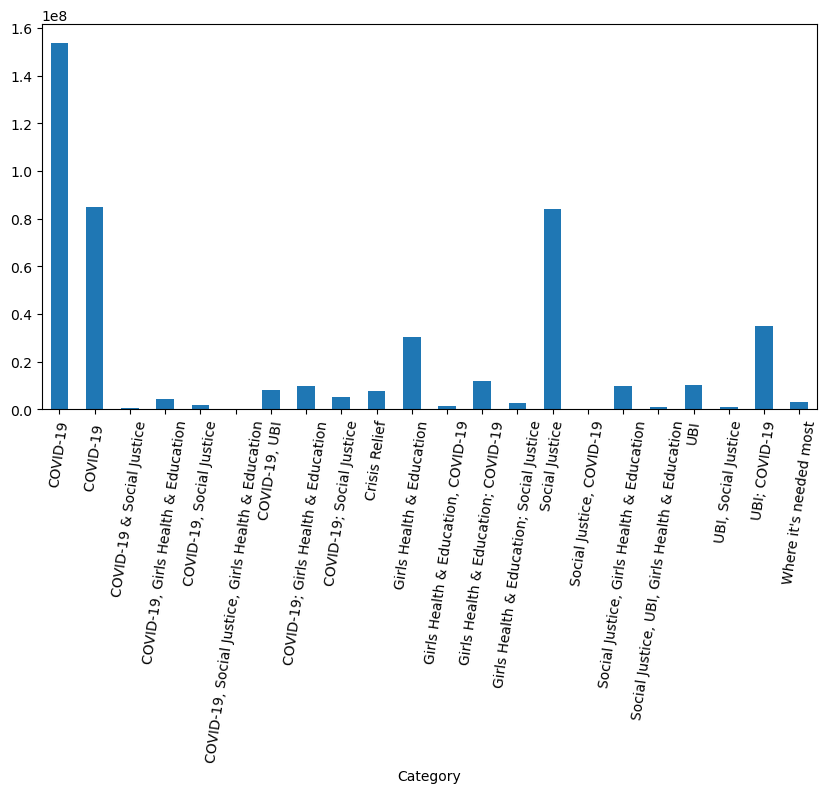

In [11]:
fig = plt.figure(figsize=(10,5))
current_funding_by_category.plot(kind='bar', rot=82)

In [12]:
grantees = ndf.groupby('Grantee')['$ amount'].sum()
grants_sorted = grantees.sort_values()
# top 10 recepients 
grants_sorted[-10:].map(lambda x: '${:3,}'.format(x))[::-1]

Grantee
Vital Strategies: Resolve To Save Lives    $38,000,000.0
CORE: Community Organized Relief Effort    $30,000,000.0
Clara Lionel Foundation                    $28,877,000.0
Reinvent Stockton Foundation               $18,000,000.0
CARE                                       $16,000,000.0
Give2SF                                    $15,000,000.0
Open Research Lab Income Project           $15,000,000.0
REFORM Alliance                            $12,000,000.0
World Central Kitchen                      $11,585,500.0
Indiana University Foundation              $10,025,000.0
Name: $ amount, dtype: object

<Axes: xlabel='Grantee'>

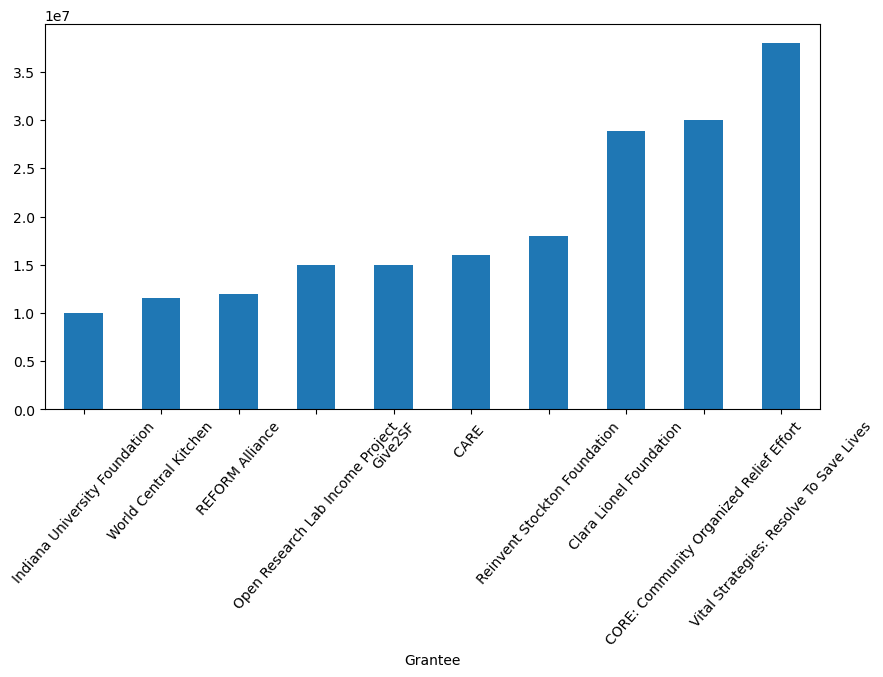

In [13]:
# largest grants
fig = plt.figure(figsize=(10,5))
ax= plt.subplot()
res = grants_sorted[-10:]

res.plot(kind='bar', rot=49)

<Axes: xlabel='Grantee'>

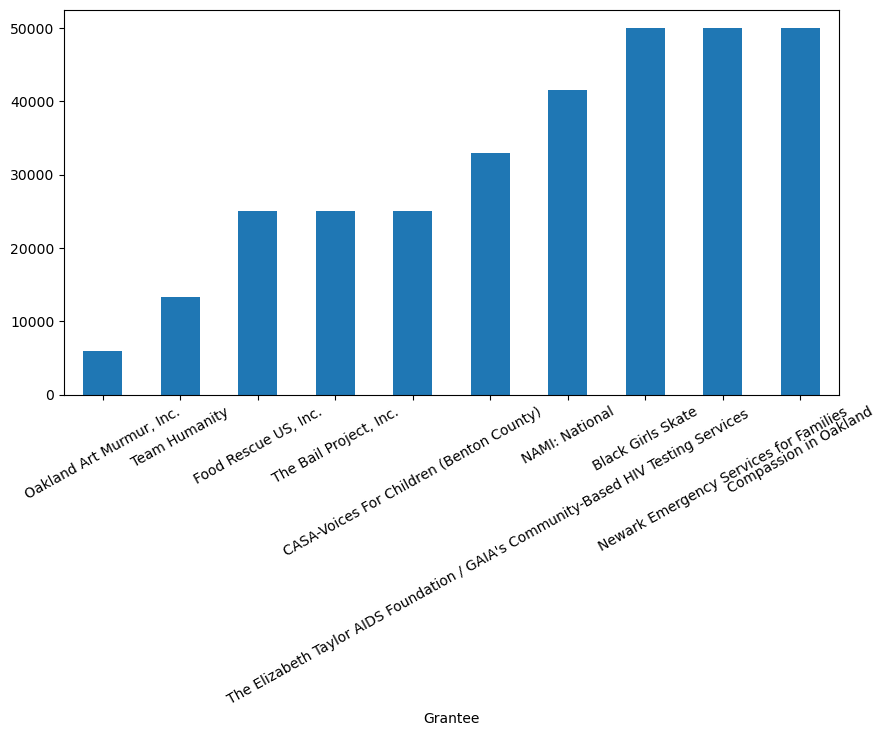

In [14]:
# smallest grants
fig = plt.figure(figsize=(10,5))
ax= plt.subplot()
res = grants_sorted[:10]

res.plot(kind='bar', rot = 29)

In [15]:
'Total Pledged ${:3,}'.format(current_funding_by_category.sum())

'Total Pledged $466,946,311.0'

In [16]:
# and this should be the same too
'Total Pledged ${:3,}'.format(grantees.sum())

'Total Pledged $466,946,311.0'

_______________________________________

# Featurize II

let's do it again and concentrate on a subset of the columns, to get a sense for the different ways to featurize named columns.
____________________________

## Topic Model

We encode the data using Topic Models. This turns the textual features into latent vectors. Likewise, we can do the same for the target data. 


Notice that we set `cardinality_threshold_target` very low and `min_words` very high to force featurization as topic models rather than one-hot or sbert embeddings;

1) encode target using a topic model, and set `n_topics_target` as the dimension of the latent target factorization. This choice is based on the fact that there are really only 4-6 or so distinct categories across the labels, but they are mixed together. The labels are in fact Hierarchical categories. We can use the topic model to find the lowest moments of this Hierarchical classification in the distributional sense. 

2) Encode the `Why?` column as a `n_topics` -dimensional factorization.

In [17]:
g = graphistry.nodes(ndf).bind(point_title='Category')

g2 = g.umap(X=['Why?'], y = ['Category'], 
            min_words=1e9, # encode as topic model by setting min_words high
            n_topics=42, # latent embedding size of `Why`
            n_topics_target=4, # turn categories into a 4dim vector of regressive targets
            cardinality_threshold_target=2, # force topic model over target `Category`
            use_scaler=None,
            use_scaler_target=None
            ) 

! Failed umap speedup attempt. Continuing without memoization speedups.* Ignoring target column of shape (285, 4) in UMAP fit, as it is not one dimensional

Plotting the result shows the similarity between entities. It does a good job overall at clustering by topic. Click in and check out some nearby nodes. 

In [20]:
g2.bind(point_title='Grantee').plot(render=RENDER)

'https://hub.graphistry.com/graph/graph.html?dataset=039654b935e6476dbe4a232e28609ae1&type=arrow&viztoken=c8fd440d-2b3a-4fbf-868c-f6c93e141154&usertag=f680a57a-pygraphistry-0.28.7&splashAfter=1672009084&info=true&play=0'

In [18]:
g2.bind(point_title='Grantee') # remove this

{'bindings': {'edges':       _src_implicit  _dst_implicit   _weight
  0                 0             12  0.259627
  1                 0             17  0.199818
  2                 0             62  0.203113
  3                 0             69  1.000000
  4                 0             70  1.000000
  ...             ...            ...       ...
  5343            284            266  0.214474
  5344            284            268  0.437251
  5345            284            269  0.260279
  5346            284            281  0.196945
  5347            284            282  0.378657
  
  [5340 rows x 3 columns],
  'nodes':       _n       Date     Amount         Category                Grantee  \
  0      0  3/21/2022  $2,000,000  Social Justice        REFORM Alliance   
  1      1  3/10/2022  $1,000,000   Crisis Relief  World Central Kitchen   
  2      2  3/10/2022  $1,000,000   Crisis Relief     Sunflower of Peace   
  3      3  3/10/2022  $1,000,000   Crisis Relief            Razom, Inc.

In [25]:
# suppose we have a minibatch of new data -- transform under the fit from the above
new_df = new_y = ndf.sample(5) # pd.DataFrame({'Category': ndf['Category'].sample(5)})
a, b = g2.transform(new_df, new_y, kind='nodes', return_graph=False)
a

,"Why?: humanitarian, ukrainian, refugees","Why?: swiftly, purposeful, 501c3","Why?: marginalized, overlapping, philippines","Why?: vulnerable, katahdin, emergency","Why?: environment, caribbean, campaigns","Why?: communities, community, comprehensive","Why?: resources, response, beygood","Why?: struggling, edgewood, insecurity","Why?: guaranteed, guarantee, startsmall","Why?: freeamerica, executive, laboratories",...,"Why?: constitution, nationwide, wrongful","Why?: engineering, pipelines, bridges","Why?: sisterhearts, incarcerated, reintegrate","Why?: professionally, professional, coaching","Why?: grassroots, tomorrow, lebanon","Why?: accountability, international, internationally","Why?: empowered, empowers, challenges","Why?: transgender, transforms, transform","Why?: distribute, partners, apartment","Why?: criminal, involved, revolving"
159,0.236916,38.588360,30.373227,0.213063,0.116198,9.704266,0.516681,0.286067,2.306019,0.143175,...,15.119652,14.739994,0.363901,0.136811,30.160732,0.347338,0.179397,14.499937,0.154706,0.216822
232,0.125822,0.126276,0.489966,23.307476,0.144480,0.405398,3.442718,93.529875,0.263075,0.224679,...,0.267978,0.245100,0.887226,1.060931,0.302779,0.161256,0.183167,0.291377,0.180761,24.022940
49,0.168831,0.095540,0.510627,0.224725,0.203497,15.177313,0.144602,0.115632,0.206232,0.183050,...,533.620486,0.143972,0.307317,0.203663,0.175756,0.224400,0.118498,0.565488,0.136513,86.074218
128,117.456651,141.573854,1.264896,61.952004,0.938442,0.226525,0.471679,0.488770,0.295840,0.198822,...,0.293674,0.240500,0.649356,71.580706,0.309401,1.495261,0.278069,0.250989,0.316268,52.594001
143,0.390299,0.705119,0.200594,0.289334,0.741111,0.211383,0.119188,0.639676,41.376138,33.728495,...,24.314660,0.456560,0.338799,6.250002,0.257315,0.169124,6.171564,0.355015,0.121650,44.124393


In [26]:
b

,"Category: justice, social, 19","Category: crisis, relief, covid","Category: education, health, girls","Category: needed, where, most"
159,0.050012,9.049035,0.050939,0.050014
232,0.050011,10.549174,0.050803,0.050012
49,18.034484,0.050009,0.051457,0.064050
128,0.053126,0.050119,32.963727,0.133029
143,18.034484,0.050009,0.051457,0.064050


In [27]:
# likewise you can play with how many edges to include using,
g2 = g2.filter_weighted_edges(scale=0.5)  # lower positive values of scale mean closer similarity 

<Axes: ylabel='support across data'>

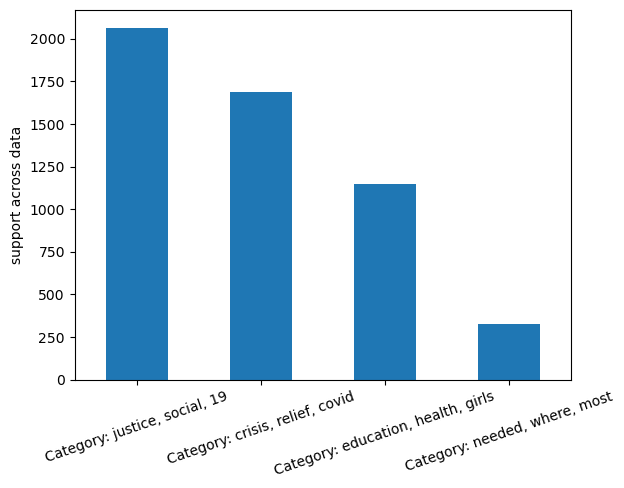

In [28]:
# find the marginal in the category topic distribution
y = g2._node_target
y.sum(0).plot(kind='bar', ylabel='support across data', rot=19)

In [29]:
# Let's see how the category columns are supported by the data
from collections import Counter
tops = y.values.argmax(1)
for topic_number in range(y.shape[1]):
    indices = np.where(tops==topic_number)
    top_category = Counter(ndf.loc[indices].Category)
    print()
    print('-'*50)
    print(f'Topic {topic_number+1}: \t\t\t\t Evidence')
    print(f'{y.columns[topic_number]}')
    print('-'*35)
    for t, c in top_category.most_common():
        print(f'-- {t},    {c}')


--------------------------------------------------
Topic 1: 				 Evidence
Category: justice, social, 19
-----------------------------------
-- Social Justice,    92
-- COVID-19; Social Justice,    8
-- COVID-19, Social Justice,    2
-- Social Justice, COVID-19,    1
-- UBI, Social Justice,    1
-- COVID-19 & Social Justice,    1

--------------------------------------------------
Topic 2: 				 Evidence
Category: crisis, relief, covid
-----------------------------------
-- COVID-19,    70
-- COVID-19 ,    55
-- Crisis Relief,    8
-- UBI,    4
-- UBI; COVID-19,    3
-- COVID-19, UBI,    2

--------------------------------------------------
Topic 3: 				 Evidence
Category: education, health, girls
-----------------------------------
-- Girls Health & Education,    16
-- COVID-19, Girls Health & Education,    4
-- Girls Health & Education; COVID-19,    3
-- COVID-19; Girls Health & Education,    3
-- Girls Health & Education, COVID-19,    2
-- Girls Health & Education; Social Justice,   

We see that different spellings, spaces, etc or use of ;, , etc map to the same topic. This is a useful way to disambiguate when there are many similar categories without having to do a lot of data cleaning and prep.

The choice of `n_topics_target` sets the prior on the Dirty_Cat GapEncoder used under the hood

_________________________________________________________________________________________
Let's add the Category Topic Number as a feature to help us visualize using the Histogram Feature of the Graphistry UI

This reduces the naive one-hot-encoding of 22 columns down the the number set by the `n_topics_target`

In [30]:
g2._nodes['topic'] = y.columns[tops]
ndf['topic'] = y.columns[tops]

In [31]:
g2._nodes.topic

0        Category: justice, social, 19
1      Category: crisis, relief, covid
2      Category: crisis, relief, covid
3      Category: crisis, relief, covid
4      Category: crisis, relief, covid
                    ...               
280    Category: crisis, relief, covid
281    Category: crisis, relief, covid
282    Category: crisis, relief, covid
283    Category: crisis, relief, covid
284    Category: crisis, relief, covid
Name: topic, Length: 285, dtype: object

------------------------------------------------------------------------------
In the plot below, use the histogram feature on the bottom right of the UI to color by `topic`


In [55]:
g2.bind(point_title='Grantee').plot(render=RENDER) # color by `topic` in histogram

In [29]:
## lets sum $$ across major topics

In [34]:
topic_sums = ndf.groupby('topic')['$ amount'].sum()
topic_sums.sort_values()[::-1].apply(lambda x : '${:3,}'.format(x))

topic
Category: crisis, relief, covid       $299,611,918.0
Category: justice, social, 19          $92,815,393.0
Category: education, health, girls     $60,235,000.0
Category: needed, where, most          $14,284,000.0
Name: $ amount, dtype: object

Hence we have Crisis Relief, Social Justice, Health Education Girls, and UBI occupying the main topics across the target

------------------------------------------------------------------------------------------
Let's move on to point 2) 
## Sentence Transformer Model

To trigger the sentence encoder, just lower the `min_words` count (which previously we had set to higher than the number of words across the `Why?` column) to some small value or zero to force encoding any X=[..] columns, since it sets the minimum number of words to consider passing on to the (sentence, ngram) embedding pipelines.  

Here, UMAP will work directly on the sentence transformer vector and expose a search interface.

In [35]:
g3 = g.umap(X = ['Why?', 'Grantee'], y = 'Category', 
            min_words=0, 
            model_name ='paraphrase-MiniLM-L6-v2', 
            cardinality_threshold_target=2,
            use_scaler=None,
            use_scaler_target=None,
            scale=0.5)

! Failed umap speedup attempt. Continuing without memoization speedups.* Ignoring target column of shape (285, 6) in UMAP fit, as it is not one dimensional

In [36]:
g3.search('carbon neutral')[0][['Why?']]

,Why?
28,Climate Justice Alliance (CJA) formed in 2013 ...
27,The Climate and Clean Energy Equity Fund (Equi...
138,The Richmond Rapid Response Fund (R3F) is a wr...
29,"The Deep South Center for Environment Justice,..."
113,"For 40 years, Futures Without Violence has pio..."
46,"DC or Nothing, Inc. is a nonprofit organizatio..."
134,To support Oxfam’s response to the ongoing imp...
54,With the support of #StartSmall ALIMA is opera...
161,"To support the ""AEGIS Study"" Fund to address S..."
39,The Caribbean Climate Justice Project seeks to...


In [37]:
# make quick semantic estimates
'${:3,}'.format(g3.search('carbon neutral')[0]['$ amount'].sum())

'$13,776,250.0'

In [38]:
g3.search('sustainable homes and communities')[0][['Why?','$ amount']]#.sum()

,Why?,$ amount
237,For the #FirstOfTheMonth rent relief project a...,530000.0
184,Funds will be used towards their mission of pr...,1000000.0
142,To support in its efforts to empower people wi...,4720000.0
225,Supports the 30-day Rent Relief program and fu...,200000.0
253,Funds support the Navajo Water Project - conne...,1000000.0
177,"To support the COVID-19 Resilience Fund, servi...",2000000.0
122,"For over 60 years, Public Health Solutions (PH...",200000.0
226,Funding to be used as leverage in negotiations...,300000.0
29,"The Deep South Center for Environment Justice,...",300000.0
110,"Mission Neighborhood Centers (MNC), founded in...",1000000.0


In [39]:
'${:3,}'.format(g3.search('sustainable homes and communities')[0]['$ amount'].sum())

'$11,250,000.0'

In [54]:
# see the queries landscape  -- paste url to see graph if g.plot(render=False)
g3.search_graph('sustainable homes and communities', scale=0.90, top_n=10).bind(point_title='Grantee').plot(render=RENDER)

In [43]:
# or transform on new data as before
a, b = g3.transform(new_df, new_y, kind='nodes', return_graph=False)
a

,Why?_Grantee_0,Why?_Grantee_1,Why?_Grantee_2,Why?_Grantee_3,Why?_Grantee_4,Why?_Grantee_5,Why?_Grantee_6,Why?_Grantee_7,Why?_Grantee_8,Why?_Grantee_9,...,Why?_Grantee_374,Why?_Grantee_375,Why?_Grantee_376,Why?_Grantee_377,Why?_Grantee_378,Why?_Grantee_379,Why?_Grantee_380,Why?_Grantee_381,Why?_Grantee_382,Why?_Grantee_383
159,0.135104,0.300215,-0.336029,0.391878,0.210208,0.204778,-0.206973,-0.421860,0.193846,0.004468,...,0.061103,-0.148403,0.142046,0.332987,0.276994,-0.018557,0.215201,-0.177418,0.198028,-0.236547
232,0.036824,-0.049116,-0.249666,-0.066719,0.144140,0.555284,-0.012072,0.110200,0.024263,0.396906,...,0.081129,-0.360361,0.097009,0.063269,0.028107,0.023804,-0.241448,-0.014664,0.340554,0.178263
49,-0.216572,-0.188459,-0.249376,-0.198563,0.276977,0.097076,-0.197303,0.090905,0.236754,0.076233,...,0.173085,0.258612,0.545030,0.005908,-0.218616,0.174977,0.339456,0.048581,0.365795,-0.131041
128,0.063737,0.072447,-0.260197,-0.147688,0.154840,0.331430,-0.135504,-0.128670,-0.170057,0.284649,...,0.510706,-0.224490,-0.001598,-0.124736,-0.154723,0.201532,-0.129054,-0.600749,0.200058,-0.114383
143,-0.122805,0.094486,-0.065283,-0.262844,0.173042,0.393647,-0.122875,-0.062536,-0.150799,0.263343,...,0.296829,-0.127015,0.088147,0.391824,-0.404938,0.050320,0.123501,0.097074,0.086858,-0.007991


In [44]:
b

,"Category: covid, ubi, 19","Category: education, health, girls","Category: justice, social, most","Category: 19, it, ubi","Category: ubi, 19, it","Category: 19, it, ubi","Category: crisis, relief, needed"
159,9.010388,0.050021,0.050002,0.072433,0.050005,0.067149,0.050002
232,10.517864,0.050018,0.050002,0.068085,0.050005,0.064023,0.050003
49,0.050001,0.051496,17.979706,0.094841,0.072941,0.050895,0.050120
128,0.050003,32.901963,0.053038,0.051484,0.120215,0.121692,0.051604
143,0.050001,0.051496,17.979706,0.094841,0.072941,0.050895,0.050120


Clicking around to nearest neighbors demonstrates good semantic similarity, as seen by the Paraphrase Model `paraphrase-MiniLM-L6-v2`

In [39]:
g3.bind(point_title='Grantee').plot(render=RENDER)

'https://hub.graphistry.com/graph/graph.html?dataset=51fe80f88c464b5eb049dd382cfb9b46&type=arrow&viztoken=ab98054f-1141-4657-b76d-9a98b4753917&usertag=f680a57a-pygraphistry-0.28.7&splashAfter=1672009108&info=true&play=0'

Suppose we wanted to add the `$ amount` column as a feature: 

To include it in the sentence transformer model, reduce the` min_words` threshold to include it. If we want the column `Grantee` to be encoded as a topic model, set `min_words` to between the average of `Why?` (higher) and `Grantee` (lower).  It nevertheless is useful across many datasets since if a column is truly categorical, its cardinality is usually well under that of a truly textual feature. Moreover, if you want all columns to be textually encoded, set `min_words=0`. 

The `$ amount` column will be passed in and scaled according to `use_scaler`, while `use_scaler_target` selects how to scale targets 

(exercise:  `use_scaler_target='kbins'` to see the difference in `g._node_target` 

or scale the dataframe directly (this transforms the batch dataframe)

`a, b = g.scale(ndf, ydf=ndf, 'nodes', use_scaler_target='kbins', n_bins=9))` 

In [45]:
g3 = g.umap(X = ['Why?', 'Grantee', '$ amount'], y = 'Category',
            min_words=2, # don't set to zero or it will stringify the `$ amount`
            model_name ='paraphrase-MiniLM-L6-v2',
            use_scaler=None,
           )

! Failed umap speedup attempt. Continuing without memoization speedups.* Ignoring target column of shape (285, 22) in UMAP fit, as it is not one dimensional

In [46]:
g3._node_encoder.text_cols

['Why?', 'Grantee']

In [42]:
g3.plot(render=RENDER) # color/size the noded by `$ amount`, mimics graph above as they use the same embedding xys

'https://hub.graphistry.com/graph/graph.html?dataset=22d84e2ef2de4cb4830ea1c6c9dc2f70&type=arrow&viztoken=b5067b0e-4c9b-4341-8c41-ce05998aacd1&usertag=f680a57a-pygraphistry-0.28.7&splashAfter=1672009127&info=true&play=0'

## NGRAMS model

Lastly, suppose we want a plain Ngrams model matrix, and for a change, one-hot-encode the target `Category`

Set `use_ngrams = True`
and set the `cardinality_threshold_target` > cardinality(`Category`).

UMAP will work directly on the ngrams matrix, and any other feature column one may transform. 

In [47]:
g4 = g.umap(X = ['Why?', 'Grantee'], y = 'Category', 
            use_ngrams=True, 
            ngram_range=(1,3), 
            min_df=2, 
            max_df=0.3,
            use_scaler=None,
            cardinality_threshold_target=400 # this will one-hot-encode the target, 
                                                # as we have less than 400 total `categories`
           )

! Failed umap speedup attempt. Continuing without memoization speedups.* Ignoring target column of shape (285, 22) in UMAP fit, as it is not one dimensional

In [44]:
g4.bind(point_title='Category').plot(render=RENDER)  # umap-ing ngrams is not as useful as sentence embeddings as you may visually see, however they can be useful graphs nonetheless. Press `play` in the UI.

'https://hub.graphistry.com/graph/graph.html?dataset=aeb09ebc8a914fe8851b7bc4ea255c9c&type=arrow&viztoken=f768c875-ee7d-4cea-b514-a3c8ba0d59bc&usertag=f680a57a-pygraphistry-0.28.7&splashAfter=1672009131&info=true&play=0'

In [48]:
g4._node_features  # a standard tfidf ngrams matrix

,reform,alliance,committed,criminal,justice,system,throughout,united,states,by,...,mayor office,for homeless,match,hospital,2m,go towards,grant 2m,will go towards,total grant 2m,clinics
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
g4._node_encoder.text_model  #sklearn pipeline 

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.3, min_df=2, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer())])

In [50]:
## vocab size
len(g4._node_encoder.text_model[0].vocabulary_)

3889

In [52]:
# or transform new data: 
emb, a, b = g4.transform_umap(new_df, new_y, kind='nodes', return_graph=False)
emb

,x,y
159,-37.624218,-14.910732
232,-0.166451,2.110077
49,6.467577,-1.822420
128,29.529594,-8.572101
143,0.627995,2.143465


Naive Indicator Variables


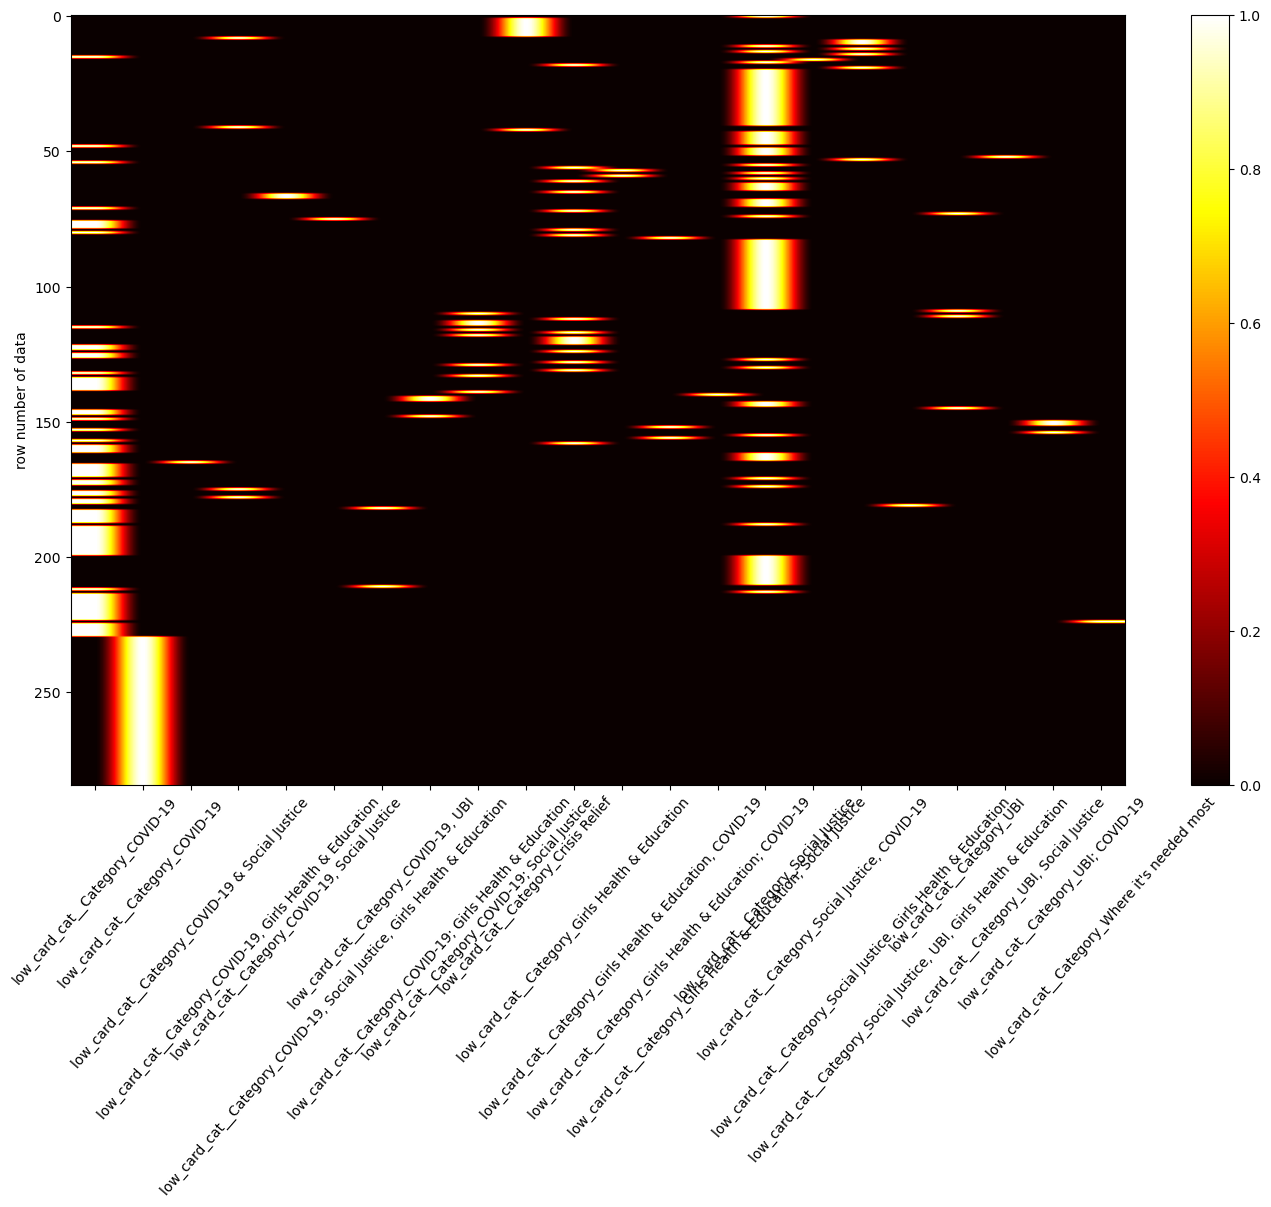

In [53]:
# we include the naive indicator variable for completeness.
y = g4._node_target
label_list = b.columns

fig = plt.figure(figsize=(17,10))
ax = plt.subplot()
plt.imshow(y, aspect='auto', cmap='hot')
plt.colorbar()
plt.ylabel('row number of data')
ax.set_xticks(range(len(label_list)))
ax.set_xticklabels(label_list, rotation=49)
print('Naive Indicator Variables')

# Contributions

Input tabular data that exists in the wild and quickly make features and graphs that allow semantic and topological exploration and traversals. 

Quickly track a variety of datasets and gauge growth, investment, and promise fullfillment and transparently using Graph Thinking and Analysis. In Jack's case, we see the possibility of a multibillion dollar edific erected around Covid-19, Girls Education and Social Justice. Further downstream modeling might tell us what such an edific is able to manufacture as a force for Good.

Encoding text, categorical, and numeric features while exploring the relationships can be time consuming tasks. 

PyGraphistry[ai] demonstrates an exciting and visually accelerated way to explore Graph Data. 

It allows quick Mix and Match featurization models and types, while pivoting on large amounts of data using natural language search, in just a few lines of code. The resulting features may then be used in downstream models.

Join our Slack: Graphistry-Community